# Attention map visualization

In [6]:
import re
import random

import torch
from pathlib import Path
import matplotlib.pyplot as plt

from arithmetic_lm.model import TransformerDecoder, load_model, find_latest_ckpt
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.interp.attn_maps import plot_head, plot_module
from arithmetic_lm.interp.hooks import (
    get_attention_map,
    generate_hooked,
    set_attn_kwargs_prehook,
)
from arithmetic_lm.constants import PLOTS_DIR, CHECKPOINTS_DIR

import warnings

warnings.filterwarnings("ignore")

plt.style.use("../figure.mplstyle")

In [2]:
tokenizer = CharTokenizer()

## Select models

In [17]:
ckpts = {
    # === generalize-to-longer ===
    # "abs_pe_shift": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_10abspeshift/step750000-train_loss1.4077-val_loss1.4930.ckpt",
    # "nope": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_nope/step284000-train_loss1.4530-val_loss1.8758.ckpt",
    # "pre_matching": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_pre_matching_v1/step400000-train_loss1.4351-val_loss1.4716.ckpt",
    # "rope": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_rotary/step116000-train_loss1.4557-val_loss2.7940.ckpt",
    # "reversed": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_abs_ansrev",
    # "normal": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head",
    # "rand_spaces_0.3": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_rand_spaces_0.5",
    # "rand_spaces_0.3": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_rand_spaces_0.3",
    # "randsp0.5_rev_ansloss": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_randsp0.5_rev_ansloss/model.ckpt",
    # === strlen_v1 ===
    # "string_length": "../checkpoints/strlen_v1/trans_dec_1layers_192embd_2head",
    # === exp 29 ===
    "Absolute PE": "../checkpoints/experiment-29/tdec_abs_randsp0_revansFalse_s2/step76000-train_loss0.0568-val_loss0.0057.ckpt",
    "Absolute PE + Random Spaces": "../checkpoints/experiment-29/tdec_abs_randsp0.5_revansFalse_s1/step100000-train_loss0.0862-val_loss0.0147.ckpt",
    "Abacus PE": "../checkpoints/experiment-29/tdec_abacus_randsp0_revansTrue_s1/step40000-train_loss0.0080-val_loss0.0000.ckpt",
}

# ckpts = {k: find_latest_ckpt(v) for k, v in ckpts.items()}

Prompt: $12345+45678= (5+5=6) True Ans: 58023$
['layers[0].self_attn', 'layers[1].self_attn', 'layers[2].self_attn']
pred_answer: 58023$
layers[0].self_attn torch.Size([1, 4, 18, 18])
layers[1].self_attn torch.Size([1, 4, 18, 18])
layers[2].self_attn torch.Size([1, 4, 18, 18])
Prompt: $12345+45678= (5+5=7) True Ans: 58023$$
['layers[0].self_attn', 'layers[1].self_attn', 'layers[2].self_attn']
pred_answer: 58023$
layers[0].self_attn torch.Size([1, 4, 18, 18])
layers[1].self_attn torch.Size([1, 4, 18, 18])
layers[2].self_attn torch.Size([1, 4, 18, 18])
Prompt: $54321+87654= (5+5=8) True Ans: $$32085$
['layers[0].self_attn', 'layers[1].self_attn', 'layers[2].self_attn']
pred_answer: 32085$
layers[0].self_attn torch.Size([1, 4, 18, 18])
layers[1].self_attn torch.Size([1, 4, 18, 18])
layers[2].self_attn torch.Size([1, 4, 18, 18])


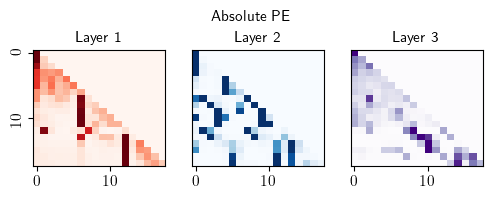

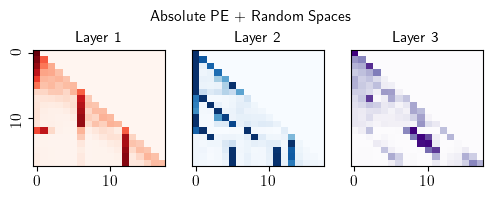

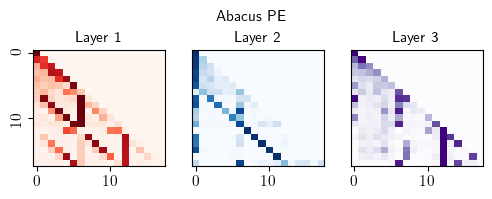

In [34]:
# general tasks

# prompt_str = "$1+2="
# true_ans = (
#     str(eval(prompt_str.replace("=", "").replace("$", "").replace(" ", ""))) + "$"
# )

a = 12345
b = 45678
true_ans = str(a + b)
a = str(a)
b = str(b)

stop_token_id = tokenizer.encode("$")[0]


for model_name, ckpt_path in ckpts.items():
    model, hparams = load_model(ckpt_path)
    reverse_ops = hparams["extra_hparams"]["data_format"]["reverse_ops"]
    reverse_ans = hparams["extra_hparams"]["data_format"]["reverse_ans"]
    filler_tokens_prompt = hparams["extra_hparams"]["data_format"][
        "filler_tokens_prompt"
    ]

    if reverse_ops:
        a = a[::-1]
        b = b[::-1]
    if reverse_ans:
        true_ans = true_ans[::-1]

    prompt_str = f"${a}+{b}="
    true_ans = true_ans + "$"
    print(
        f"Prompt: {prompt_str} ({len(a)}+{len(b)}={len(true_ans)}) True Ans: {true_ans}"
    )

    prompt = tokenizer.encode(prompt_str, return_tensors=True)

    module_names = [mn for mn, _ in model.named_modules() if mn.endswith("self_attn")]
    # replace index to get correct syntax
    module_names = [re.sub(r"\.(\d+)\.", r"[\1].", mn) for mn in module_names]
    print(module_names)

    attn_maps = {}

    # generate answer
    pred_tensor = generate_hooked(
        model,
        prompt=prompt,
        stop_token=stop_token_id,
        hook_config={
            mn: {
                "hook": get_attention_map(mn, attn_maps),
                "pre_hook": set_attn_kwargs_prehook,
            }
            for mn in module_names
        },
    )

    pred_answer_str = tokenizer.decode(pred_tensor[0].tolist())
    print("pred_answer:", pred_answer_str)

    for mn, matts in attn_maps.items():
        print(mn, matts.shape)

    # tokens for easier visualization
    ticks = list(prompt_str + pred_answer_str)

    # for each module, in a subfigure plot heads as subplots
    fig, axs = plt.subplots(1, 3, figsize=(5.8, 1.5))
    fig.suptitle(f"{model_name}", y=1.15)

    # choose cmaps for combined attn map
    cmaps = ["Reds", "Blues", "Purples", "Greens", "Oranges"]

    # take max over heads for each layer
    for i, (mn, matts) in enumerate(attn_maps.items()):
        attn_maps[mn] = matts.amax(dim=1).squeeze()

    # plot layers
    for i, (mn, matts) in enumerate(attn_maps.items()):
        axs[i].imshow(matts, cmap=cmaps[i], aspect="auto")

        # set axs name
        axs[i].set_title(f"Layer {i+1}")

        # only keep yticks for first plot
        if i != 0:
            axs[i].set_yticks([])

    # rotate yticks
    for ax in axs:
        ax.tick_params(axis="y", rotation=90)

    # save
    plt.savefig(
        "../latex/fig/attn_map_"
        + model_name.lower()
        .replace(" ", "_")
        .replace("absolute", "abs")
        .replace("+_", "")
        + ".png",
        bbox_inches="tight",
        dpi=300,
    )